# Machine Exercise 7
### Prepared by: CAYAS, Ryan Roi [2022-22085]

## Prerequisites

We first import the required packages and load the necessary files.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, f1_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Part I. Early Stage Diabetes Risk Prediction

In [15]:
diabetes_df = pd.read_csv('diabetes_data_upload.csv', sep=',')
diabetes_df

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [4]:
diabetes_df.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [3]:
for col in diabetes_df:
    print(diabetes_df[col].unique())

[40 58 41 45 60 55 57 66 67 70 44 38 35 61 54 43 62 39 48 32 42 52 53 37
 49 63 30 50 46 36 51 59 65 25 47 28 68 56 31 85 90 72 69 79 34 16 33 64
 27 29 26]
['Male' 'Female']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['Yes' 'No']
['Yes' 'No']
['Positive' 'Negative']


In [16]:
# OneHotEncode the Gender column
diabetes_df = pd.get_dummies(diabetes_df, columns=['Gender'], dtype=int, drop_first=True)
    # drop first category to avoid multicollinear features

# Initialize LabelEncoder for binary columns
binary_columns = ['Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness',
                  'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching',
                  'Irritability', 'delayed healing', 'partial paresis', 
                  'muscle stiffness', 'Alopecia', 'Obesity']

# Directly mapping 'Yes' to 1 and 'No' to 0 for binary columns
diabetes_df[binary_columns] = diabetes_df[binary_columns].replace({'Yes': 1, 'No': 0})

# Encode the class column using mapping
diabetes_df['class'] = diabetes_df['class'].map({'Positive': 1, 'Negative': 0})
diabetes_df.head()

,Age,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,Gender_Male
0,40,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1,1
1,58,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,1
2,41,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,1
3,45,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,1
4,60,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1


In [17]:
y = diabetes_df['class']
X = diabetes_df.drop('class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [18]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
def objective(trial):
    model_name = trial.suggest_categorical('model', ['MLP', 'Random Forest', 'XGBoost', 'Logistic Regression', 'Naive Bayes', 'SVM', 'kNN'])
    
    if model_name == 'MLP':
        params = {
            'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes', 50, 300, step=50),
            'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
            'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
            'max_iter': trial.suggest_int('max_iter', 200, 1000)
        }
        model = MLPClassifier(**params, random_state=42)
    
    elif model_name == 'Random Forest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
        }
        model = RandomForestClassifier(**params, random_state=42)
    
    elif model_name == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
        }
        model = XGBClassifier(**params, random_state=42)
    
    elif model_name == 'Logistic Regression':
        params = {
            'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
            'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
            'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
        }
        model = LogisticRegression(**params, random_state=42)
    
    elif model_name == 'Naive Bayes':
        model = GaussianNB()
    
    elif model_name == 'SVM':
        params = {
            'C': trial.suggest_float('C', 1e-4, 1e2, log=True),
            'gamma': trial.suggest_float('gamma', 1e-4, 1e-1, log=True),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        }
        model = SVC(**params, random_state=42)
    
    elif model_name == 'kNN':
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
            'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
        }
        model = KNeighborsClassifier(**params)
    
    score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy').mean()
    return score


In [26]:
study = optuna.create_study(direction='maximize', study_name='Diabetes Risk Prediction')
study.optimize(objective, n_trials=100)

# Print the best trial's details
best_trial = study.best_trial
print(f'Best model: {best_trial.params["model"]}')
print(f'Best parameters: {best_trial.params}')
print(f'Best accuracy: {best_trial.value}')

[I 2024-06-12 16:14:44,930] A new study created in memory with name: Diabetes Risk Prediction
[I 2024-06-12 16:14:45,495] Trial 0 finished with value: 0.6153310104529617 and parameters: {'model': 'XGBoost', 'n_estimators': 139, 'max_depth': 20, 'learning_rate': 0.0013327655274120802, 'subsample': 0.9371475186004985, 'colsample_bytree': 0.6689795415285651}. Best is trial 0 with value: 0.6153310104529617.
[I 2024-06-12 16:14:45,513] Trial 1 finished with value: 0.9182926829268293 and parameters: {'model': 'Logistic Regression', 'C': 0.06894221315310718, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.9182926829268293.
[I 2024-06-12 16:14:46,299] Trial 2 finished with value: 0.9470383275261325 and parameters: {'model': 'XGBoost', 'n_estimators': 280, 'max_depth': 17, 'learning_rate': 0.006630618252259127, 'subsample': 0.60114282874799, 'colsample_bytree': 0.6134881915638299}. Best is trial 2 with value: 0.9470383275261325.
[I 2024-06-12 16:14:50,098] Trial 3 finished wit

Best model: MLP
Best parameters: {'model': 'MLP', 'hidden_layer_sizes': 250, 'alpha': 5.694785392914491e-05, 'learning_rate_init': 0.0006282264179351859, 'max_iter': 559}
Best accuracy: 0.9784552845528456


In [27]:
# Initialize the best model with the best parameters
best_model_name = best_trial.params['model']

if best_model_name == 'MLP':
    best_model = MLPClassifier(
        hidden_layer_sizes=best_trial.params['hidden_layer_sizes'],
        alpha=best_trial.params['alpha'],
        learning_rate_init=best_trial.params['learning_rate_init'],
        max_iter=best_trial.params['max_iter'],
        random_state=42
    )
elif best_model_name == 'Random Forest':
    best_model = RandomForestClassifier(
        n_estimators=best_trial.params['n_estimators'],
        max_depth=best_trial.params['max_depth'],
        min_samples_split=best_trial.params['min_samples_split'],
        min_samples_leaf=best_trial.params['min_samples_leaf'],
        max_features=best_trial.params['max_features'],
        random_state=42
    )
elif best_model_name == 'XGBoost':
    best_model = XGBClassifier(
        n_estimators=best_trial.params['n_estimators'],
        max_depth=best_trial.params['max_depth'],
        learning_rate=best_trial.params['learning_rate'],
        subsample=best_trial.params['subsample'],
        colsample_bytree=best_trial.params['colsample_bytree'],
        random_state=42
    )
elif best_model_name == 'Logistic Regression':
    best_model = LogisticRegression(
        C=best_trial.params['C'],
        penalty=best_trial.params['penalty'],
        solver=best_trial.params['solver'],
        random_state=42
    )
elif best_model_name == 'Naive Bayes':
    best_model = GaussianNB()

elif best_model_name == 'SVM':
    best_model = SVC(
        C=best_trial.params['C'],
        gamma=best_trial.params['gamma'],
        kernel=best_trial.params['kernel'],
        random_state=42
    )
elif best_model_name == 'kNN':
    best_model = KNeighborsClassifier(
        n_neighbors=best_trial.params['n_neighbors'],
        weights=best_trial.params['weights'],
        metric=best_trial.params['metric']
    )

# Train the model on the entire training set
best_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test_scaled)

# Calculate Accuracy and F1-score on the test set
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_trial.params}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-score: {f1:.4f}")


Best Model: MLP
Best Parameters: {'model': 'MLP', 'hidden_layer_sizes': 250, 'alpha': 5.694785392914491e-05, 'learning_rate_init': 0.0006282264179351859, 'max_iter': 559}
Test Accuracy: 0.9615
Test F1-score: 0.9613


In [6]:
def objective2(trial):
    params = {
        'hidden_layer_sizes': tuple(trial.suggest_int(f'hidden_layer_size{i}', 50, 300, step=50) for i in range(1, trial.suggest_int('n_layers', 1, 3) + 1)),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        'max_iter': trial.suggest_int('max_iter', 200, 1000)
    }
    model = MLPClassifier(**params, random_state=42)

    score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy').mean()
    return score

study2 = optuna.create_study(direction='maximize', study_name='MLP Optimization')
study2.optimize(objective2, n_trials=20)

# Print the best trial's details
best_trial2 = study2.best_trial
print(f'Best parameters: {best_trial2.params}')
print(f'Best accuracy: {best_trial2.value}')

[I 2024-06-12 15:24:09,407] A new study created in memory with name: MLP Optimization
[I 2024-06-12 15:24:10,569] Trial 0 finished with value: 0.9710801393728221 and parameters: {'n_layers': 3, 'hidden_layer_size1': 100, 'hidden_layer_size2': 50, 'hidden_layer_size3': 100, 'alpha': 0.00010258310438043133, 'learning_rate_init': 0.027158216646730567, 'max_iter': 931}. Best is trial 0 with value: 0.9710801393728221.
[I 2024-06-12 15:24:16,388] Trial 1 finished with value: 0.9759581881533101 and parameters: {'n_layers': 1, 'hidden_layer_size1': 300, 'alpha': 0.0007058220168481954, 'learning_rate_init': 0.0018627250683533364, 'max_iter': 931}. Best is trial 1 with value: 0.9759581881533101.
[I 2024-06-12 15:24:18,474] Trial 2 finished with value: 0.976074332171893 and parameters: {'n_layers': 1, 'hidden_layer_size1': 100, 'alpha': 0.00028021104966350995, 'learning_rate_init': 0.007796524504901454, 'max_iter': 239}. Best is trial 2 with value: 0.976074332171893.
[I 2024-06-12 15:24:21,103] T

Best parameters: {'n_layers': 1, 'hidden_layer_size1': 100, 'alpha': 0.00028021104966350995, 'learning_rate_init': 0.007796524504901454, 'max_iter': 239}
Best accuracy: 0.976074332171893


In [10]:
fig = optuna.visualization.plot_slice(study2, params=['hidden_layer_size1','max_iter','alpha','learning_rate_init'])
fig.show()

In [9]:
# Train the best model on the entire training set
best_params2 = best_trial2.params

# Adjust hidden_layer_sizes parameter
hidden_layer_sizes = tuple(best_params2[f'hidden_layer_size{i}'] for i in range(1, best_params2['n_layers'] + 1))

best_model2 = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    alpha=best_params2['alpha'],
    learning_rate_init=best_params2['learning_rate_init'],
    max_iter=best_params2['max_iter'],
    random_state=42
)

# Fit the best model on the training set
best_model2.fit(X_train_scaled, y_train)

# Predict and evaluate on the test set
y_pred = best_model2.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label=1)

print(f'Test Accuracy: {accuracy}')
print(f'Test F1-score: {f1}')

# Plot the optimization history
fig = optuna.visualization.plot_optimization_history(study2)
fig.show()

# Plot parameter importance
fig = optuna.visualization.plot_param_importances(study2)
fig.show()


Test Accuracy: 0.9615384615384616
Test F1-score: 0.9692307692307692


## Part 2: Predicting High School Student Performance

In [32]:
student_df = pd.read_csv('student-mat.csv', sep=';')
student_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [12]:
student_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [13]:
for col in student_df:
    print(student_df[col].unique())

['GP' 'MS']
['F' 'M']
[18 17 15 16 19 22 20 21]
['U' 'R']
['GT3' 'LE3']
['A' 'T']
[4 1 3 2 0]
[4 1 2 3 0]
['at_home' 'health' 'other' 'services' 'teacher']
['teacher' 'other' 'services' 'health' 'at_home']
['course' 'other' 'home' 'reputation']
['mother' 'father' 'other']
[2 1 3 4]
[2 3 1 4]
[0 3 2 1]
['yes' 'no']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['yes' 'no']
['yes' 'no']
['no' 'yes']
['no' 'yes']
[4 5 3 1 2]
[3 2 4 1 5]
[4 3 2 1 5]
[1 2 5 3 4]
[1 3 2 4 5]
[3 5 1 2 4]
[ 6  4 10  2  0 16 14  7  8 25 12 54 18 26 20 56 24 28  5 13 15 22  3 21
  1 75 30 19  9 11 38 40 23 17]
[ 5  7 15  6 12 16 14 10 13  8 11  9 17 19 18  4  3]
[ 6  5  8 14 10 15 12 18 16 13  9 11  7 19 17  4  0]
[ 6 10 15 11 19  9 12 14 16  5  8 17 18 13 20  7  0  4]


In [33]:
# One-hot encoding for non-ordinal features
non_ordinal_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian']
student_df = pd.get_dummies(student_df, columns=non_ordinal_features, dtype=int, drop_first=True)

# Encode yes/no features
yes_no_features = ['schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']
student_df[yes_no_features] = student_df[yes_no_features].replace({'yes': 1, 'no': 0})

student_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,...,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other
0,18,4,4,2,2,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,17,1,1,1,2,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,15,1,1,1,2,3,1,0,1,0,...,0,0,1,0,0,0,1,0,1,0
3,15,4,2,1,3,0,0,1,1,1,...,0,0,0,1,0,1,0,0,1,0
4,16,3,3,1,2,0,0,1,1,0,...,0,0,1,0,0,1,0,0,0,0


In [36]:
y = student_df['G3']
X = student_df.drop('G3', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
# Define an objective function for Linear Regression
def objective_lr(trial):
    model = LinearRegression()
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(r2_score))
    mean_cv_score = np.mean(cv_scores)
    return mean_cv_score

# Define an objective function for Random Forest
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(r2_score))
    mean_cv_score = np.mean(cv_scores)
    return mean_cv_score

# Define an objective function for Gradient Boosting
def objective_gb(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(r2_score))
    mean_cv_score = np.mean(cv_scores)
    return mean_cv_score

# Define an objective function for XGBoost
def objective_xgb(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, use_label_encoder=False, eval_metric='rmse')
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(r2_score))
    mean_cv_score = np.mean(cv_scores)
    return mean_cv_score


In [52]:
# Create and optimize studies for each model
studies = {
    "LinearRegression": optuna.create_study(direction="maximize"),
    "RandomForest": optuna.create_study(direction="maximize"),
    "GradientBoosting": optuna.create_study(direction="maximize"),
    "XGBoost": optuna.create_study(direction="maximize")
}

objectives = {
    "LinearRegression": objective_lr,
    "RandomForest": objective_rf,
    "GradientBoosting": objective_gb,
    "XGBoost": objective_xgb
}

for model_name in studies:
    print(f"Optimizing {model_name}...")
    studies[model_name].optimize(objectives[model_name], n_trials=50)

[I 2024-06-12 17:16:26,160] A new study created in memory with name: no-name-821c4800-1087-4cfa-b2ab-c0051e354711
[I 2024-06-12 17:16:26,163] A new study created in memory with name: no-name-0bd8ff68-f1d2-43be-9713-1d5ebdb07e26
[I 2024-06-12 17:16:26,164] A new study created in memory with name: no-name-48978b89-1756-49ca-9bf2-2d8eeb19c24a
[I 2024-06-12 17:16:26,166] A new study created in memory with name: no-name-90d134a5-bb5a-4bd3-9da9-484f01ee535e
[I 2024-06-12 17:16:26,288] Trial 0 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,318] Trial 1 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,340] Trial 2 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,387] Trial 3 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 

Optimizing LinearRegression...


[I 2024-06-12 17:16:26,421] Trial 4 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,471] Trial 5 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,506] Trial 6 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,533] Trial 7 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,565] Trial 8 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,603] Trial 9 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.7959109184676558.
[I 2024-06-12 17:16:26,633] Trial 10 finished with value: 0.7959109184676558 and parameters: {}. Best is trial 0 with value: 0.795910918

Optimizing RandomForest...


[I 2024-06-12 17:16:28,850] Trial 1 finished with value: 0.8733518357342798 and parameters: {'n_estimators': 98, 'max_depth': 14}. Best is trial 1 with value: 0.8733518357342798.
[I 2024-06-12 17:16:29,022] Trial 2 finished with value: 0.8659989549590081 and parameters: {'n_estimators': 40, 'max_depth': 6}. Best is trial 1 with value: 0.8733518357342798.
[I 2024-06-12 17:16:29,301] Trial 3 finished with value: 0.8750662465403967 and parameters: {'n_estimators': 58, 'max_depth': 15}. Best is trial 3 with value: 0.8750662465403967.
[I 2024-06-12 17:16:29,478] Trial 4 finished with value: 0.8671398700876767 and parameters: {'n_estimators': 36, 'max_depth': 16}. Best is trial 3 with value: 0.8750662465403967.
[I 2024-06-12 17:16:29,895] Trial 5 finished with value: 0.8763258562719487 and parameters: {'n_estimators': 88, 'max_depth': 13}. Best is trial 5 with value: 0.8763258562719487.
[I 2024-06-12 17:16:29,959] Trial 6 finished with value: 0.8537478759519533 and parameters: {'n_estimators

Optimizing GradientBoosting...


[I 2024-06-12 17:16:43,472] Trial 1 finished with value: 0.8328118128371745 and parameters: {'n_estimators': 54, 'learning_rate': 0.23156630530988606, 'max_depth': 8}. Best is trial 1 with value: 0.8328118128371745.
[I 2024-06-12 17:16:43,671] Trial 2 finished with value: 0.6625973445090826 and parameters: {'n_estimators': 14, 'learning_rate': 0.05063398279694597, 'max_depth': 17}. Best is trial 1 with value: 0.8328118128371745.
[I 2024-06-12 17:16:43,857] Trial 3 finished with value: 0.8128337203114911 and parameters: {'n_estimators': 32, 'learning_rate': 0.049026879316583845, 'max_depth': 8}. Best is trial 1 with value: 0.8328118128371745.
[I 2024-06-12 17:16:44,011] Trial 4 finished with value: 0.8228761400682728 and parameters: {'n_estimators': 26, 'learning_rate': 0.10576253364979121, 'max_depth': 14}. Best is trial 1 with value: 0.8328118128371745.
[I 2024-06-12 17:16:44,288] Trial 5 finished with value: 0.8220945296933515 and parameters: {'n_estimators': 48, 'learning_rate': 0.0

Optimizing XGBoost...


[I 2024-06-12 17:16:54,199] Trial 0 finished with value: 0.8579606631929092 and parameters: {'n_estimators': 39, 'learning_rate': 0.21176481317989126, 'max_depth': 13}. Best is trial 0 with value: 0.8579606631929092.
[I 2024-06-12 17:16:54,662] Trial 1 finished with value: 0.8461382068918809 and parameters: {'n_estimators': 74, 'learning_rate': 0.07265386631869025, 'max_depth': 11}. Best is trial 0 with value: 0.8579606631929092.
[I 2024-06-12 17:16:54,827] Trial 2 finished with value: 0.584876137766352 and parameters: {'n_estimators': 31, 'learning_rate': 0.020435289998877514, 'max_depth': 19}. Best is trial 0 with value: 0.8579606631929092.
[I 2024-06-12 17:16:55,233] Trial 3 finished with value: 0.8554238748379724 and parameters: {'n_estimators': 63, 'learning_rate': 0.1683918328317385, 'max_depth': 13}. Best is trial 0 with value: 0.8579606631929092.
[I 2024-06-12 17:16:55,320] Trial 4 finished with value: 0.8752614098411037 and parameters: {'n_estimators': 40, 'learning_rate': 0.1

In [53]:
# Retrieve the best parameters for each model
best_params = {model_name: study.best_trial.params for model_name, study in studies.items()}
print("Best parameters per model:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

# Train and evaluate each model with the best parameters
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(**best_params["RandomForest"]),
    "GradientBoosting": GradientBoostingRegressor(**best_params["GradientBoosting"]),
    "XGBoost": XGBRegressor(**best_params["XGBoost"], use_label_encoder=False, eval_metric='rmse')
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {"R²": r2}

print("R² on test set for each model:")
for model_name, scores in results.items():
    print(f"{model_name}: R² = {scores['R²']}")

Best parameters per model:
LinearRegression: {}
RandomForest: {'n_estimators': 63, 'max_depth': 7}
GradientBoosting: {'n_estimators': 75, 'learning_rate': 0.10893700338665795, 'max_depth': 2}
XGBoost: {'n_estimators': 41, 'learning_rate': 0.16597524328728447, 'max_depth': 2}
R² on test set for each model:
LinearRegression: R² = 0.788132132115856
RandomForest: R² = 0.8680346705330656
GradientBoosting: R² = 0.8648237572144122
XGBoost: R² = 0.8663617412511848


In [ ]:
# cant install on mac
!pip install -q lazypredict
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
# cant install on mac
!pip install -q auto-sklearn
import autosklearn.regression

# Initialize the auto-sklearn regressor
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=3600, per_run_time_limit=300)

# Fit the model
automl.fit(X_train, y_train)

# Predict on the test set
y_pred = automl.predict(X_test)

# Evaluate the model
r2_score = automl.score(X_test, y_test)
print(f"R² on the test set: {r2_score}")

# Get the results for all models
cv_results = automl.cv_results_

# Report R² scores for all models
for i, (mean_test_score, params) in enumerate(zip(cv_results['mean_test_score'], cv_results['params'])):
    print(f"Model {i+1}: R² = {mean_test_score:.4f}, Parameters: {params}")

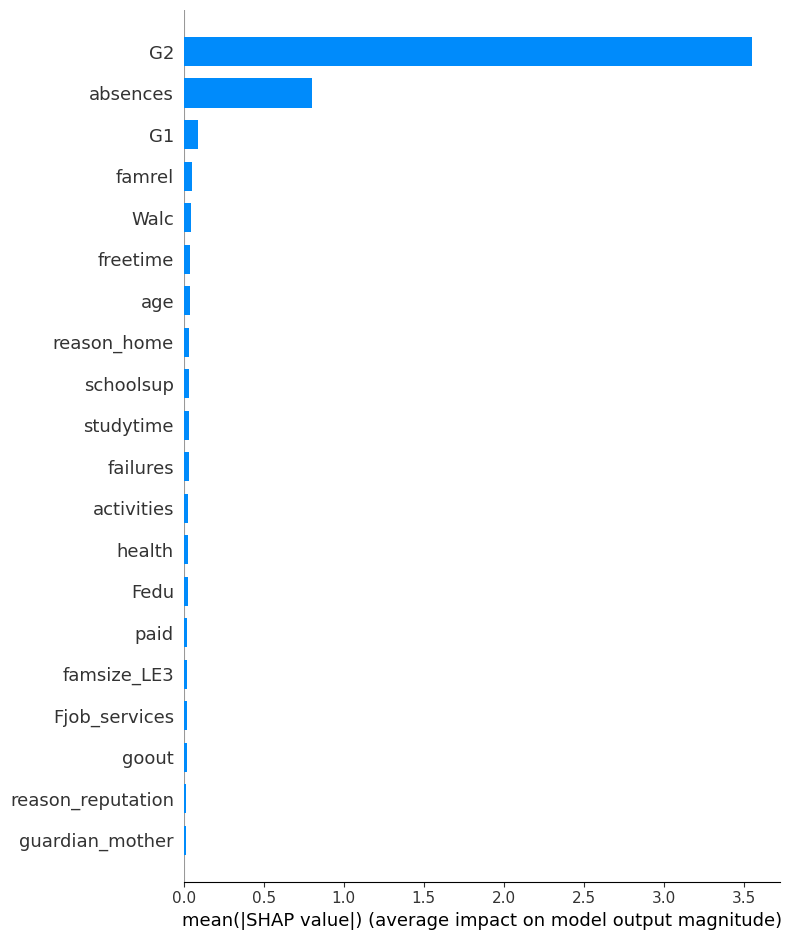

In [58]:
y_pred = models['RandomForest'].predict(X_test)

explainer = shap.TreeExplainer(models['RandomForest'])
shap_values = explainer.shap_values(X_test)

# Plot the feature importance using SHAP
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [78]:
shap_values = explainer.shap_values(X_test)
print(shap_values)

[[-0.00015886  0.00176046 -0.06589347 ...  0.00709856  0.00771728
   0.00511078]
 [ 0.00573708  0.00046905  0.01464992 ... -0.00294722 -0.02820177
   0.00392517]
 [-0.02593878  0.01962558 -0.01504171 ... -0.00562544  0.03503808
   0.00278219]
 ...
 [ 0.02719234 -0.00385962  0.01557279 ... -0.00386976  0.0434249
   0.00254574]
 [-0.04971663 -0.00040483  0.00823268 ... -0.00678855 -0.0160153
  -0.01354208]
 [ 0.07161668  0.0138966   0.02777183 ... -0.00843674 -0.01213725
   0.0164679 ]]


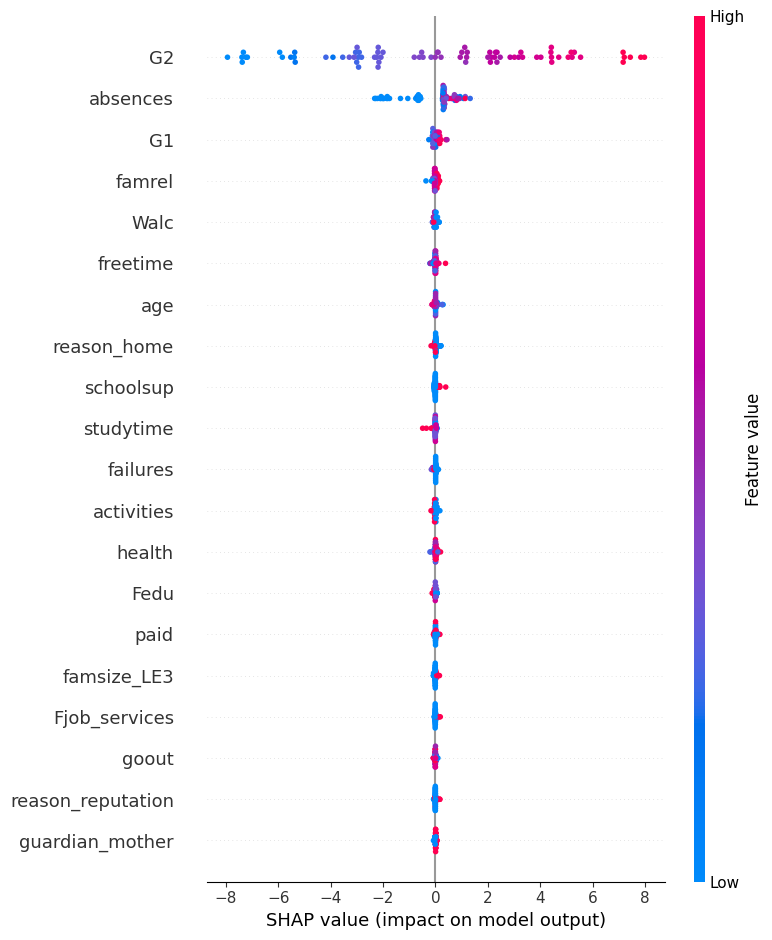

In [80]:
shap.summary_plot(shap_values, X_test)


From the summary plots, it can be easily distinguished that the second period grades are the most influential to the students' third period grade. In general, the higher a students' second period grades are, the more likely their third period grades are also high, i.e. G2 and G3 grades are directly proportional. In fact, the G2 grades have an average impact of about 3.5 on the third period grades. This is in contract to the next most important feature which is the number of absences, which only has an average impact of less than 1.

From the second summary plot which shows the direction of each features' impact, it seems that students' with low absences had poorer third period grades, which is not intuitive. This may have been possible because the students with low G2 grades also happen to have few absences.